# Diffmah
Run Andrew's diffmah model on halos from LJ to explore the smooth mass accretion history of different types of halos (fossils, non-fossils, rugs, etc.)

In [ ]:
import copy
import h5py
import pickle
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import haccytrees.mergertrees
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter

from diffmah.diffmah.load_mah_data import load_tng_data, TASSO
from diffmah.diffmah.fit_mah_helpers import get_loss_data
from diffmah.diffmah.fit_mah_helpers import log_mah_mse_loss_and_grads
from diffmah.diffmah.utils import jax_adam_wrapper
from diffmah.diffmah.individual_halo_assembly import _calc_halo_history
from diffmah.diffmah.individual_halo_assembly import _get_early_late

redshifts = np.flip(np.array([10.044, 9.8065, 9.5789, 9.3608, 9.1515, 8.7573, 8.5714, 8.3925, 8.0541, 7.8938, 7.7391, 7.4454, 7.3058, 7.04, 6.9134, 6.6718, 6.5564, 6.3358, 6.1277, 6.028, 5.8367, 5.6556, 5.4839, 5.3208, 5.2422, 5.0909, 4.9467, 4.7429, 4.6145, 4.4918, 4.3743, 4.2618, 4.1015, 4.00, 3.8551, 3.763, 3.6313, 3.5475, 3.4273, 3.3133, 3.205, 3.102, 3.0361, 2.9412, 2.8506, 2.7361, 2.6545, 2.5765, 2.4775, 2.4068, 2.3168, 2.2524, 2.1703, 2.0923, 2.018, 1.9472, 1.8797, 1.7994, 1.7384, 1.68, 1.6104, 1.5443, 1.4938, 1.4334, 1.3759, 1.321, 1.2584, 1.2088, 1.152, 1.1069, 1.0552, 1.006, 0.9591, 0.9143, 0.8646, 0.824, 0.7788, 0.7358, 0.6948, 0.6557, 0.6184, 0.5777, 0.5391, 0.5022, 0.4714, 0.4337, 0.4017, 0.3636, 0.3347, 0.3035, 0.2705, 0.2423, 0.2123, 0.1837, 0.1538, 0.1279, 0.1008, 0.0749, 0.0502, 0.0245, 0.00]))

%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees
plt.rc('figure', facecolor='w')

In [ ]:
linestyles = iter(["a", "b", "c"])
print(next(linestyles))
print(next(linestyles))
new_ls = linestyles
print(next(new_ls))

In [ ]:
import diffmah
simulation = haccytrees.Simulation.simulations['LastJourney'] # read in a chunk of simulation
cosmic_time = simulation.cosmo.lookback_time(1e-10) - simulation.step2lookback(np.array(simulation.cosmotools_steps))
fig, ax = plt.subplots()
ax.plot(cosmic_time) # cosmic time vs timesteps

In [ ]:
%%time
forest, progenitor_array = haccytrees.mergertrees.read_forest(
    '/data/a/cpac/mbuehlmann/LastJourney/forest/target_forest_aurora.hdf5',
    'LastJourney', nchunks=1, chunknum=0, mass_threshold = 2.7*10**11,
    include_fields = ["tree_node_mass", "snapnum", "fof_halo_tag", "sod_halo_cdelta", "fof_halo_center_x", "fof_halo_center_y", "fof_halo_center_z"]
)

In [ ]:
%%time
fg_forest, fg_progenitor_array = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest.hdf5",
    'LastJourney'
)

## Get halo samples (via masking)

In [ ]:
fg_masks = help_func_haccytrees.make_masks(fg_forest)
halo_masks = help_func_haccytrees.make_masks(forest) # All z=0 halos # Same as `halo_masks2 = make_masks(forest, target_idx = target_idx)` because of mass bins

### Helper Function

In [ ]:
# Calculate their parameters
def calc_subset_params(log_mah_sim, size, t_tng, log_mah_fit_min, non_fg_rugs_mrich):
    
    subset_params = np.zeros((size, 5))
    for ihalo in range(size):
        if ihalo % 100 == 0:
            print("ihalo: ", ihalo)
        # I think cosmic_time is now t_tng, mainbranch_peakmass is now log_mah_sim, and min_mass is now log_mah_fit_min
        
        p_init, loss_data = get_loss_data(t_tng, log_mah_sim[ihalo], log_mah_fit_min) # np.log10(log_mah_sim[ihalo])
        n_step = 150 # or  200?
        _res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_step, n_warmup=1)
        p_best, loss, loss_arr, params_arr, fit_terminates = _res
        logtc, ue, ul = p_best
        logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data
        early, late = _get_early_late(ue, ul) 
        tarr = np.linspace(0.75, 13.8, 500) # age of the universe things?
        lgtarr = np.log10(tarr)
        dmhdt_fit, log_mah_fit = _calc_halo_history(lgtarr, lgtarr[-1], logmp_fit, logtc, k, early, late) # Is logtc the new x0?
        subset_params[ihalo,:] = [logmp_fit, early, late, logtc, non_fg_rugs_mrich[ihalo]] # x0 is now logtc

    return subset_params

# Multi-sample: The Main Event

In [ ]:
%%time
mass_bin = 0
my_fg_mask = fg_masks[mass_bin]
my_halo_mask = halo_masks[mass_bin]

# Define sample sizes
rs_sample_size = 1000
fg_sample_size = 1000
np.random.seed(0)

# Find rugs within fg_forest
fg_rugs_idx = np.nonzero(my_fg_mask)[0]
fg_rugs_mainbranch_index, fg_rugs_mainbranch_masses = help_func_haccytrees.get_branches(fg_rugs_idx, fg_forest)
fg_rugs_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_rugs_mainbranch_index)
fg_rugs_major_mergers = help_func_haccytrees.get_major_mergers(fg_rugs_mainbranch_mergers)
fg_rugs_lmm_redshift = help_func_haccytrees.get_lmms(fg_rugs_major_mergers)
fgs, rugs, mrich = help_func_haccytrees.find_specials(fg_forest, fg_rugs_mainbranch_index, fg_rugs_major_mergers, fg_rugs_lmm_redshift, fg_rugs_idx)
# Get the last size
if rugs != []:
    rugs_sample_size = 300 #len(rugs)
    size = fg_sample_size + rugs_sample_size + rs_sample_size
else:
    rugs_sample_size = 0 #len(rugs)
    size = fg_sample_size + rugs_sample_size

# Make a mask for fgs, rugs, and rs's
fg_rug_rs = np.zeros_like(np.arange(size))
fg_rug_rs[0:rs_sample_size] = 0
fg_rug_rs[rs_sample_size: rs_sample_size + fg_sample_size] = 1 # + 1 on that second one? I don't think so...
if rugs != []:
    fg_rug_rs[rs_sample_size + fg_sample_size:] = 2 # used to end with rs_sample_size + fg_sample_size + rugs_sample_size       
#print(len(fg_rug_rs[fg_rug_rs == 0]))
#print(len(fg_rug_rs[fg_rug_rs == 1]))
#print(len(fg_rug_rs[fg_rug_rs == 2]))

# Get random samples + branches for:
#   Random sample
rs_idx = np.nonzero(my_halo_mask)[0]
rs_subset = np.random.choice(rs_idx, rs_sample_size)
rs_mainbranch_index, rs_mainbranch_masses = help_func_haccytrees.get_branches(rs_subset, forest) # is this really how the masking works?
rs_mainbranch_peakmass = np.maximum.accumulate(rs_mainbranch_masses, axis=1)

# I think everything above this line is still correct? Theoretically??

#   FGs + Rugs
fg_subset = np.random.choice(fg_rugs_idx, fg_sample_size) # cut this part: [np.argwhere(~np.isin(fg_idx, rugs))[0]]
fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fg_subset, fg_forest)
fg_mainbranch_peakmass = np.maximum.accumulate(fg_mainbranch_masses, axis=1)

#   Just Rugs
if rugs != []:
    rugs_subset = np.random.choice(rugs, rugs_sample_size)
    rugs_mainbranch_index, rugs_mainbranch_masses = help_func_haccytrees.get_branches(rugs, fg_forest)
    rugs_mainbranch_peakmass = np.maximum.accumulate(rugs_mainbranch_masses, axis=1)
    # Put all branches together
    ss_mainbranch_peakmass = np.log10(np.concatenate((rs_mainbranch_peakmass, fg_mainbranch_peakmass, rugs_mainbranch_peakmass)))
    subset = np.concatenate((rs_subset, fg_subset, rugs_subset))  
else: 
    # Put all branches together
    ss_mainbranch_peakmass = np.log10(np.concatenate((rs_mainbranch_peakmass, fg_mainbranch_peakmass)))
    subset = np.concatenate((rs_subset, fg_subset))

ss_mainbranch_peakmass[~np.isfinite(ss_mainbranch_peakmass)] = 0

tpeak = cosmic_time[np.argmax(ss_mainbranch_peakmass, axis=1)] # Go check out this part
min_mass = np.log10(100*simulation.particle_mass)

# Load into function
#print(ss_mainbranch_peakmass.shape)
#print(cosmic_time)
#print("into the function")
# should cosmic_time be tpeak instead? # Definitely not, it's the wrong shape (and that's not how you did it before)
#all_subset_params_matched = calc_subset_params(ss_mainbranch_peakmass, size, tpeak, min_mass, fg_rug_rs)

In [8]:
%%time
all_subset_params_matched = calc_subset_params(ss_mainbranch_peakmass, size, cosmic_time, min_mass, fg_rug_rs) # p_init is shape of number of params. How many params do I have? 3 fg, rugs, rs, but are those really parameters?

ihalo:  0
ihalo:  100
ihalo:  200
ihalo:  300
ihalo:  400
ihalo:  500
ihalo:  600
ihalo:  700
ihalo:  800
ihalo:  900
ihalo:  1000
ihalo:  1100
ihalo:  1200
ihalo:  1300
ihalo:  1400
ihalo:  1500
ihalo:  1600
ihalo:  1700
ihalo:  1800
ihalo:  1900
ihalo:  2000
ihalo:  2100
ihalo:  2200
CPU times: user 26min 26s, sys: 4min 28s, total: 30min 54s
Wall time: 22min 45s


### Add z80/z50 columns
Make an array of the values you want for each entry, then add that to the `pickled_params` dictionary with the key "z50" (or "z80", as the case may be).

Subset has the indices for the random sample (from `forest`), fg sample (from `fg_forest`), and rugs (also from `fg_forest`). Might be easier just to go by individual subsets.

In [10]:
z80s_lst = np.array([])
z50s_lst = np.array([])

if rugs != []:
    subsets = [rs_subset, fg_subset, rugs_subset]
    forests = [forest, fg_forest, fg_forest]
else:
    subsets = [rs_subset, fg_subset]
    forests = [forest, fg_forest]

for this_subset, this_forest in zip(subsets, forests):
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(this_subset, this_forest) # Yes you did this before, but you want chunks
    z80s = help_func_haccytrees.get_zfracs(this_forest, redshifts, this_subset, mainbranch_masses, frac = 0.8)
    z50s = help_func_haccytrees.get_zfracs(this_forest, redshifts, this_subset, mainbranch_masses, frac = 0.5)
    z80s_lst = np.concatenate((z80s_lst, z80s))
    z50s_lst = np.concatenate((z50s_lst, z50s))

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


### Pickle those

In [ ]:
# Pickle those results
param_dict_matched = {"final_mass" : all_subset_params_matched[:,0], "alpha_early": all_subset_params_matched[:,1], "alpha_late": all_subset_params_matched[:,2], "transition_time": all_subset_params_matched[:,3], "rs_fg_rug": all_subset_params_matched[:,4], 'z50s': z50s_lst, 'z80s': z80s_lst}
# Pickle the dictionary
pickle.dump(param_dict_matched, open( "save_new_bin" + str(mass_bin) + ".p", "wb" )) # Is that protocol correct?

In [25]:
pickled_params = pickle.load( open( "save_new_bin" + str(mass_bin) + ".p", "rb" ) )
print(pickled_params)
print(len(pickled_params['z80s']))
pickled_params

{'final_mass': array([13.03588676, 13.01484966, 13.04757214, ..., 13.01095486,
       13.0074892 , 13.00387764]), 'alpha_early': array([3.85562968, 1.53492582, 2.05148697, ..., 2.19705725, 2.15747094,
       3.71588826]), 'alpha_late': array([0.07935498, 0.13189717, 1.03325653, ..., 0.50566876, 0.57051975,
       0.66830403]), 'transition_time': array([ 0.47018793,  1.49330854, -0.28108484, ...,  0.13771306,
        0.11362828, -0.07105497]), 'rs_fg_rug': array([0., 0., 0., ..., 2., 2., 2.]), 'z50s': array([0.9591, 0.7788, 0.824 , ..., 1.152 , 1.0552, 1.2088]), 'z80s': array([0.6184, 0.0502, 0.2705, ..., 0.6184, 0.4337, 0.3636])}
2300


{'final_mass': array([13.03588676, 13.01484966, 13.04757214, ..., 13.01095486,
        13.0074892 , 13.00387764]),
 'alpha_early': array([3.85562968, 1.53492582, 2.05148697, ..., 2.19705725, 2.15747094,
        3.71588826]),
 'alpha_late': array([0.07935498, 0.13189717, 1.03325653, ..., 0.50566876, 0.57051975,
        0.66830403]),
 'transition_time': array([ 0.47018793,  1.49330854, -0.28108484, ...,  0.13771306,
         0.11362828, -0.07105497]),
 'rs_fg_rug': array([0., 0., 0., ..., 2., 2., 2.]),
 'z50s': array([0.9591, 0.7788, 0.824 , ..., 1.152 , 1.0552, 1.2088]),
 'z80s': array([0.6184, 0.0502, 0.2705, ..., 0.6184, 0.4337, 0.3636])}

## Plot

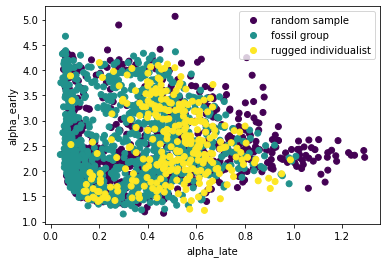

In [42]:
# Pick what to compare
param_names = ["final_mass", "alpha_early", "alpha_late", "transition_time", "rs_fg_rug", "z50s", "z80s"]
x_param = "alpha_late"
y_param = "alpha_early"
markers = np.array(['o', 'X', 'd']) # Maybe someday this will work?

# Single panel
fig, ax = plt.subplots()
scatter = ax.scatter(pickled_params[x_param], pickled_params[y_param], c = pickled_params["rs_fg_rug"])#, marker = markers[pickled_params['non_fg_rug_mrich']])
ax.set_xlabel(x_param)
ax.set_ylabel(y_param)

# Unnecessarily complicated legend
label_names = ["random sample", "fossil group", "rugged individualist"] # Why
plt.legend(handles=scatter.legend_elements()[0], labels=label_names) # Why is this all that's needed? Does it automatically split by color?
#fig.savefig(x_param + "_vs_" + y_param + "_no_mrich.png")

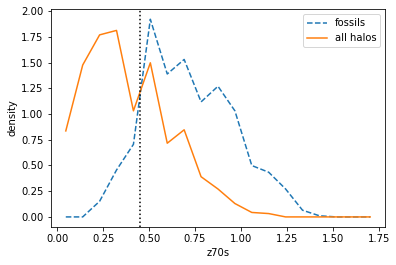

In [73]:
# Compare to histograms of z50s and such
# Multiple bins
use_density = True
frac = 0.7

if frac == 0.8:
    name = "z80s"
    axline = 0.2#0.4
elif frac == 0.7:
    name = "z70s"
    axline = 0.45
elif frac == 0.5:
    name = "z50s"
    axline = 1
elif frac == 0.25:
    name = "z25s"
    axline = 1.5
elif frac == 0.1:
    name = "z10s"
    axline = 2
elif frac == 0.04:
    name = "z4s"
    axline = 3.5
    
zbins = np.linspace(0, zbin_peak, 20)
fig, ax = plt.subplots()

rs_mainbranch_index, rs_mainbranch_masses = help_func_haccytrees.get_branches(rs_subset, forest)
rs_zfracs = help_func_haccytrees.get_zfracs(forest, redshifts, rs_subset, rs_mainbranch_masses, frac = frac)

# random sample
fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fg_subset, fg_forest)
fg_zfracs = help_func_haccytrees.get_zfracs(fg_forest, redshifts, fg_subset, fg_mainbranch_masses, frac = frac)

# Plot histograms
labels = iter(["fossils", "all halos"])
linestyles = iter(["--", "-"])

if use_density:
    for j, z50s in enumerate([fg_zfracs, rs_zfracs]):
        current_label = next(labels)
        current_linestyle = next(linestyles)
        hist = np.histogram(z50s, zbins, density = True) # still don't really understand how this is different from dividing by norm factor?
        norm_factor = len(z50s)
        bin_centers = (hist[1][:-1] + hist[1][1:]) / 2
        ax.plot(bin_centers, hist[0], label = current_label, linestyle = current_linestyle)
        ax.set_ylabel("density")

else: # Why?
    sim = haccytrees.Simulation.simulations['LastJourney']
    zsteps = sim.step2z(np.array(sim.cosmotools_steps))
    zmean = 0.5*(zsteps[1:] + zsteps[:-1])
    dz = zsteps[:-1] - zsteps[1:] # z_previous - z_current
    
    for z50s in [fg_zfracs, rs_zfracs]:
        current_label = next(labels)
        current_linestyle = next(linestyles)
        counts = np.zeros_like(dz)

        for j in range(1, len(zsteps)): # len(zsteps), maybe len(counts) instead?
            counts[j-1] = np.sum(np.isclose(z50s, zsteps[j], atol=1e-3)) #1e-5
        counts /= len(z50s)*dz # counts = probability that z50 is within dz
        ax.plot(zmean, counts, label=current_label, linestyle=current_linestyle)
        ax.set_ylabel("dp(z) / dz")
ax.legend()
ax.set_xlabel(name)
ax.axvline(axline, color = 'black', linestyle = ':')

In [10]:
# If you want only the first n values
my_dict_values = np.reshape(list(pickled_params.values()), [7,size])[:,:2000]
my_dict_keys = list(pickled_params.keys())
my_dict = {my_dict_keys[0] : my_dict_values[0], my_dict_keys[1] : my_dict_values[1], my_dict_keys[2] : my_dict_values[2], my_dict_keys[3] : my_dict_values[3], my_dict_keys[4] : my_dict_values[4], my_dict_keys[5] : my_dict_values[5], my_dict_keys[6] : my_dict_values[6]}

print(my_dict)
print(my_dict_values.shape)
print(subset[0:2000].shape)
print(subset[0:2000])
print(subset.shape)

{'final_mass': array([13.03588676, 13.01484966, 13.04757214, ..., 13.02865601,
       13.01060963, 13.01803112]), 'alpha_early': array([3.85562968, 1.53492582, 2.05148697, ..., 2.12059999, 1.79305243,
       2.35116553]), 'alpha_late': array([0.07935498, 0.13189717, 1.03325653, ..., 0.58345681, 0.50041825,
       0.30550256]), 'transition_time': array([ 0.47018793,  1.49330854, -0.28108484, ...,  0.30849826,
        0.37448317,  0.3435671 ]), 'rs_fg_rug': array([0., 0., 0., ..., 1., 1., 1.]), 'z50s': array([0.9591, 0.7788, 0.824 , ..., 1.2088, 0.9143, 1.3759]), 'z80s': array([0.6184, 0.0502, 0.2705, ..., 0.2423, 0.2123, 0.3636])}
(7, 2000)
(2000,)
[ 25035125  32275825  25994555 ... 315738528 611305234 472568049]
(2300,)


### Adjust the keys/values in pickled_params

In [64]:
my_params = pickled_params
my_subset = subset
my_param_names = ["final_mass", "alpha_early", "alpha_late", "transition_time", "rs_fg_rug", "z50s", "z80s"]
n_params = 7

# If you only want some of the keys
subsample_keys = True
if subsample_keys:
    my_params = {}
    n_params = 6
    for key in list(pickled_params)[7-n_params:]: # loop over the keys, skip the first one
        my_params[key] = pickled_params[key]
    my_param_names = my_param_names[7-n_params:]
print(len(list(my_params)))

# If you want only the first n values
subsample_values = False
if subsample_values:
    n = 2100
    my_dict_values = np.reshape(list(my_params.values()), [n_params,size])[:,:n]
    my_dict_keys = list(my_params.keys())
    my_params = {my_dict_keys[0] : my_dict_values[0], my_dict_keys[1] : my_dict_values[1], my_dict_keys[2] : my_dict_values[2], my_dict_keys[3] : my_dict_values[3], my_dict_keys[4] : my_dict_values[4], my_dict_keys[5] : my_dict_values[5]}
    my_subset = subset[:n]
#print(my_params)
print(len(my_params['alpha_late']))

6
2300


## Plot Scatter Penguin Plots

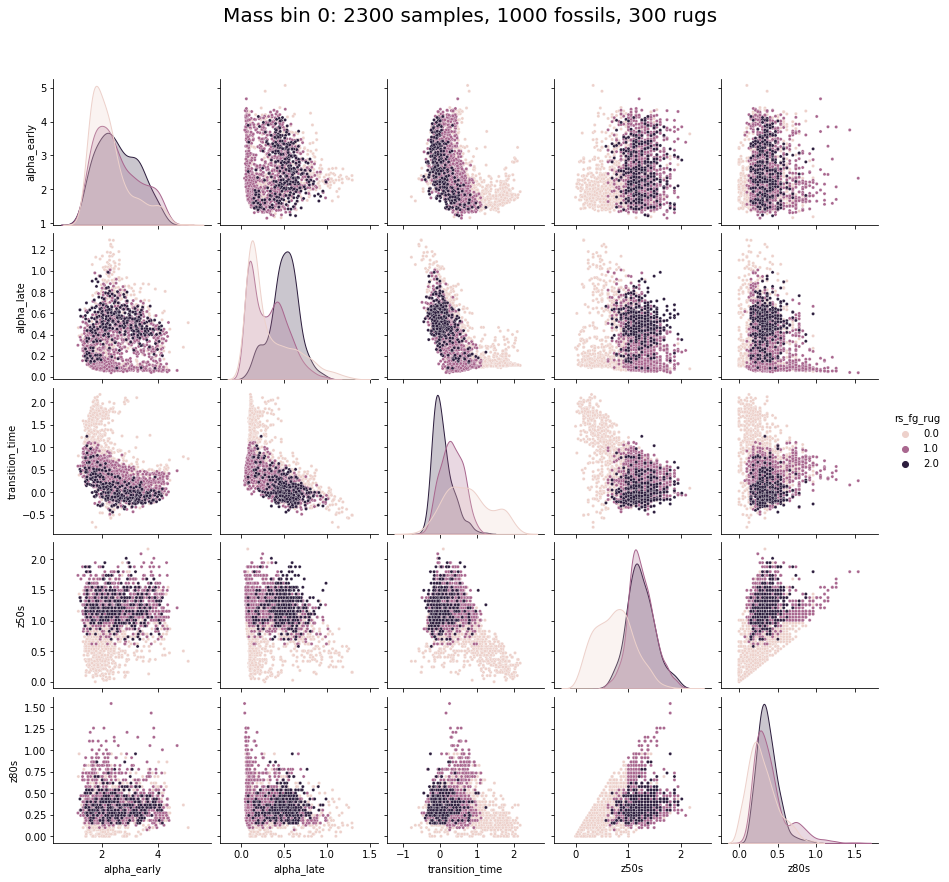

In [65]:
df = pd.DataFrame(my_params, index = my_subset, columns = my_param_names)
colors = ["#5D3A9B", "#E66100", "#009E73"]
customPalette = sns.set_palette(sns.color_palette(colors))
fig = sns.pairplot(df, hue="rs_fg_rug", diag_kws = {'common_norm': False}, plot_kws=dict(marker="o", s=10), palette = customPalette) #marker
fig.fig.suptitle("Mass bin " + str(mass_bin) + ": " + str(size) + " samples, " + str(fg_sample_size) + " fossils, " + str(rugs_sample_size) + " rugs", fontsize = 20)
fig.fig.subplots_adjust(top=0.9)
#fig.savefig("full_lj_plots/pair_plot_hue" + str(size) + "_bin" + str(mass_bin) + ".png") 

## Plot Contour Penguin Plots

None


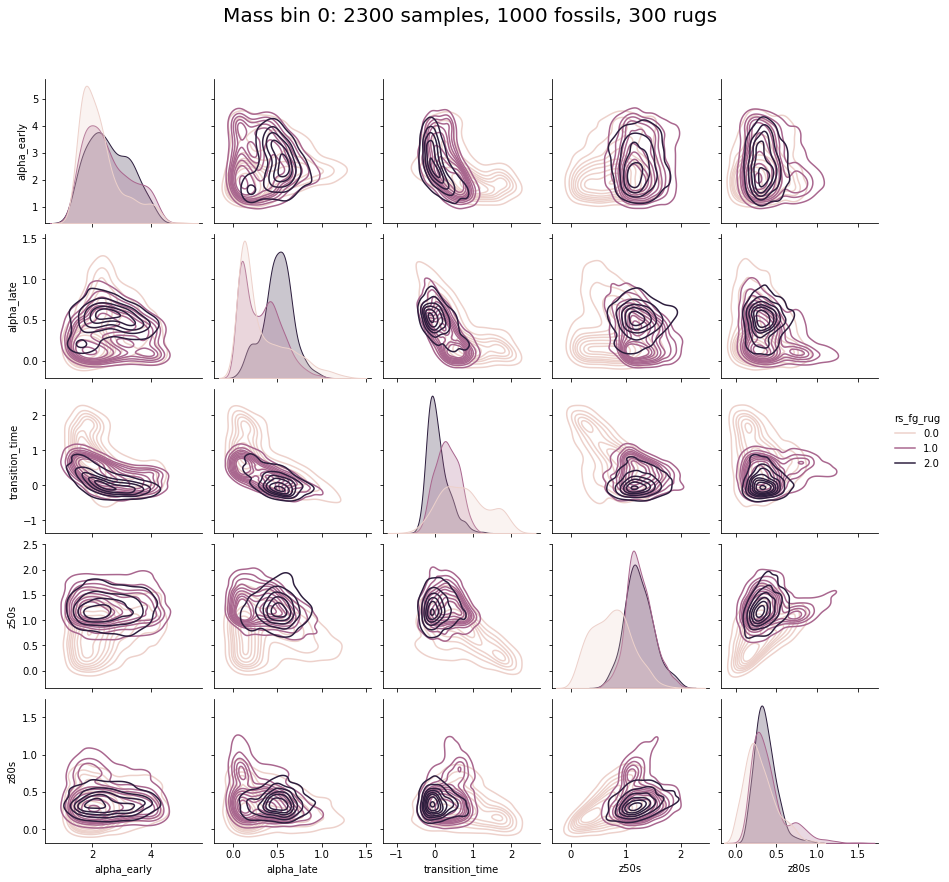

In [66]:
# With contours
df = pd.DataFrame(my_params, index = my_subset, columns = my_param_names)

colors = ["#5D3A9B", "#E66100", "#009E73"]
customPalette = sns.set_palette(sns.color_palette(colors))
fig = sns.pairplot(df, hue="rs_fg_rug", diag_kws = {'common_norm': False}, kind = 'kde', palette = customPalette) #marker
fig.fig.suptitle("Mass bin " + str(mass_bin) + ": " + str(size) + " samples, " + str(fg_sample_size) + " fossils, " + str(rugs_sample_size) + " rugs", fontsize = 20)
fig.fig.subplots_adjust(top=0.9)

#fig.savefig("full_lj_plots/pair_plot_hue" + str(size) + "_kde_bin" + str(mass_bin) + ".png")

### KDE Plot

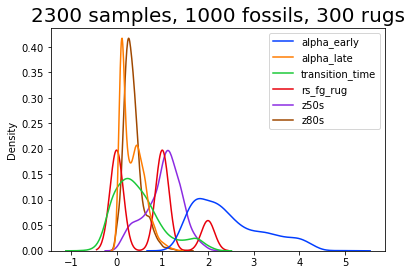

In [73]:
# KDE plot
df = pd.DataFrame(my_params, index = my_subset, columns = my_param_names)

fig = sns.kdeplot(data = df, palette = 'bright') #marker
plt.title(str(size) + " samples, " + str(fg_sample_size) + " fossils, " + str(rugs_sample_size) + " rugs", fontsize = 20)
plt.subplots_adjust(top=0.9)
#fig.savefig("pair_plot_hue" + str(size) + ".png")

## Side Quest: how many fgs and rugs in rs?

In [ ]:
print("How many fgs and rugs in the random sample?")
rs_mainbranch_index, rs_mainbranch_masses = help_func_haccytrees.get_branches(rs_subset, forest)
rs_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(forest, progenitor_array, rs_mainbranch_index)
rs_major_mergers = help_func_haccytrees.get_major_mergers(rs_mainbranch_mergers)
rs_lmm_redshift = help_func_haccytrees.get_lmms(rs_major_mergers) # Used to have lmm_index
rs_fgs, rs_rugs, rs_mrich = help_func_haccytrees.find_specials(forest, rs_mainbranch_index, rs_major_mergers, rs_lmm_redshift, rs_subset)
print("FGs,  rugs, fraction (rugs)/(rugs + FGs)")
print(len(rs_fgs), " ", len(rs_rugs), "  ", len(rs_rugs)/(len(rs_fgs) + len(rs_rugs)))

print("\nWhat about rugs in fgs?")
fg_mainbranch_index, fg_mainbranch_masses = help_func_haccytrees.get_branches(fg_subset, fg_forest)
fg_mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, fg_mainbranch_index)
fg_major_mergers = help_func_haccytrees.get_major_mergers(fg_mainbranch_mergers)
fg_lmm_redshift = help_func_haccytrees.get_lmms(fg_major_mergers) # Used to have lmm_index
fg_fgs, fg_rugs, fg_mrich = help_func_haccytrees.find_specials(fg_forest, fg_mainbranch_index, fg_major_mergers, fg_lmm_redshift, fg_subset)
print("FGs,  rugs, fraction (rugs)/(rugs + FGs)")
print(len(fg_fgs), " ", len(fg_rugs), " ", len(fg_rugs)/(len(fg_fgs) + len(fg_rugs)))

## Average MAH profiles

In [22]:
rs_avg_peakmass = np.average(ss_mainbranch_peakmass[0:1000], axis = 0)
fg_avg_peakmass = np.average(ss_mainbranch_peakmass[1000:2000], axis = 0)
rug_avg_peakmass = np.average(ss_mainbranch_peakmass[2000:2300], axis = 0)

rs_avg_tt = np.average(pickled_params['transition_time'][0:1000], axis = 0)
fg_avg_tt = np.average(pickled_params['transition_time'][1000:2000], axis = 0)
rug_avg_tt = np.average(pickled_params['transition_time'][2000:2300], axis = 0)
#print(rs_avg_tt, fg_avg_tt, rug_avg_tt)

random sample
early:  4.1537704
late:  0.6297338
transition time:  0.33963197 

FG candidates
early:  2.5770466
late:  0.39540717
transition time:  0.27678907 

rugged individualists
early:  2.8494048
late:  0.54616207
transition time:  -0.0022573145 



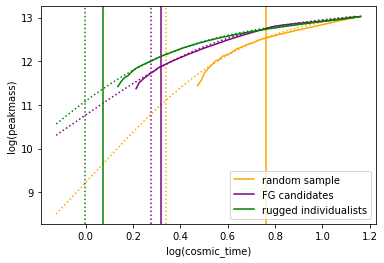

In [27]:
tpeak = cosmic_time[np.argmax(mainbranch_peakmass, axis=1)]
min_mass = 100*simulation.particle_mass

fig, ax = plt.subplots(1, 1)
colors = iter(["orange", "purple", "green"])
labels = iter(["random sample", "FG candidates", "rugged individualists"])
for this_peakmass, this_avg_tt in zip([rs_avg_peakmass, fg_avg_peakmass, rug_avg_peakmass], [rs_avg_tt, fg_avg_tt, rug_avg_tt]):
    current_color = next(colors)
    current_label = next(labels)f

    p_init, loss_data = get_loss_data(cosmic_time, this_peakmass, np.log10(min_mass)) # np.log10(log_mah_sim[ihalo])
    n_step = 150 # or  200?
    _res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_step, n_warmup=1)
    p_best, loss, loss_arr, params_arr, fit_terminates = _res
    logtc, ue, ul = p_best
    logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data
    early, late = _get_early_late(ue, ul) 
    tarr = np.linspace(0.75, 13.8, 500) # age of the universe things?
    lgtarr = np.log10(tarr)
    dmhdt_fit, log_mah_fit = _calc_halo_history(lgtarr, lgtarr[-1], logmp_fit, logtc, k, early, late) # Is logtc the new x0?
    
    # Plot average of mahs
    ax.plot(logt_target, log_mah_target, linestyle = '-', color = current_color, label = current_label)
    ax.axvline(this_avg_tt, linestyle = '-', color = current_color)

    # Plot diffmah of average
    ax.plot(lgtarr, log_mah_fit, linestyle = ':', color = current_color)
    ax.axvline(logtc, linestyle = ':', color = current_color)
    
    # Print best-fit params (for diffmah of the avg)
    print(current_label)
    print("early: ", early)
    print("late: ", late)
    print("transition time: ", logtc, "\n")
    
ax.legend()
ax.set_ylabel("log(peakmass)")
ax.set_xlabel("log(cosmic_time)")
fig.savefig("diffmah_averages.png")

### Individual MAHs

## About Merger-Rich Groups
How many major mergers is a normal amount?

In [ ]:
# Go find some fossil groups! and other specials
absolute_threshold = True
threshold = 5e11
z_thresh = 1
restrict_mass = True
use_sigma = True
mrich_thresh = 0.1
mlim = [1e13, 10**14.5] # We're going to go ahead and call this a "very thin mass bin," so that we can treat M_0 as constant
target_idx = help_func_haccytrees.find_halos(forest, mlim)
mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(target_idx, forest)
mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold)
major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers, threshold)
lmm_redshift = help_func_haccytrees.get_lmms(major_mergers, threshold)
fgs, rugs, mrich = help_func_haccytrees.find_specials(forest, mainbranch_index, major_mergers, lmm_redshift, target_idx, z_thresh, mrich_thresh = mrich_thresh, restrict_mass = restrict_mass, use_sigma = use_sigma, mainbranch_masses = mainbranch_masses)
mainbranch_peakmass = np.maximum.accumulate(mainbranch_masses, axis=1)
print(len(target_idx))
print(len(fgs))
print(len(rugs))
print(len(mrich))

307993


Text(0, 0.5, 'count')

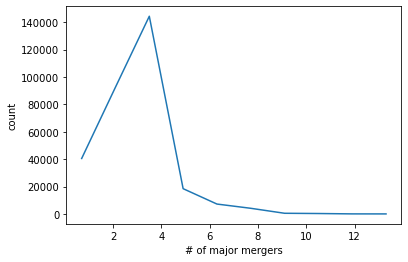

In [46]:
# How many major mergers is a normal amount?
print(len(target_idx))
mergers_count = np.zeros(len(major_mergers))
for i in range(len(major_mergers)):
    mask = major_mergers[i] > 0
    mergers_count[i] = len(major_mergers[i][mask])
mergers_count
hist = np.histogram(mergers_count)
bin_centers = (hist[1][:-1] + hist[1][1:])/2
fig, ax = plt.subplots()
ax.plot(bin_centers, hist[0])
ax.set_xlabel("# of major mergers")
ax.set_ylabel("count")